In [1]:
import warnings
warnings.filterwarnings("ignore",message=r"Passing \(type, 1\) or '1type' as a synonym of type is deprecated",category=FutureWarning)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import argparse
import os

from train import train
from task import Trial, generate_trials
from network import Model
import tools


import matplotlib.pyplot as plt
import numpy as np
import json

# this is the list of every task implemented already
# ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
#               'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
#               'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
#               'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']



2025-06-25 20:22:54.936127: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 20:22:55.081900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750875775.139040   21822 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750875775.154654   21822 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 20:22:55.289119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
num_ring = 2
n_rule = 1
n_eachring = 32
n_input, n_output = 1+num_ring*n_eachring+n_rule, n_eachring+1
ruleset = 'all'
rule_trains = ['reactgo']
N = 64

my_hp = {
            # batch size for training
            'batch_size_train': 64,
            # batch_size for testing
            'batch_size_test': 512,
            # input type: normal, multi
            'in_type': 'normal',
            # Type of RNNs: LeakyRNN, LeakyGRU, EILeakyGRU, GRU, LSTM
            'rnn_type': 'LeakyRNN',
            # whether rule and stimulus inputs are represented separately
            'use_separate_input': False,
            # Type of loss functions
            'loss_type': 'lsq',
            # Optimizer
            'optimizer': 'adam',
            # Type of activation runctions, relu, softplus, tanh, elu
            'activation': 'relu',
            # Time constant (ms)
            'tau': 100,
            # discretization time step (ms)
            'dt': 20,
            # discretization time step/time constant
            'alpha': 0.2,
            # recurrent noise
            'sigma_rec': 0.05,
            # input noise
            'sigma_x': 0.01,
            # leaky_rec weight initialization, diag, randortho, randgauss
            'w_rec_init': 'randortho',
            # a default weak regularization prevents instability
            'l1_h': 0,
            # l2 regularization on activity
            'l2_h': 0,
            # l2 regularization on weight
            'l1_weight': 0,
            # l2 regularization on weight
            'l2_weight': 0,
            # l2 regularization on deviation from initialization
            'l2_weight_init': 0,
            # proportion of weights to train, None or float between (0, 1)
            'p_weight_train': None,
            # Stopping performance
            'target_perf': 1.,
            # number of units each ring
            'n_eachring': n_eachring,
            # number of rings
            'num_ring': num_ring,
            # number of rules
            'n_rule': n_rule,
            # first input index for rule units
            'rule_start': 1+num_ring*n_eachring,
            # number of input units
            'n_input': n_input,
            # number of output units
            'n_output': n_output,
            # number of recurrent units
            'n_rnn': 256,
            # number of input units
            'ruleset': ruleset,
            # name to save
            'save_name': 'test',
            # learning rate
            'learning_rate': 0.001,
            # intelligent synapses parameters, tuple (c, ksi)
            'c_intsyn': 0,
            'ksi_intsyn': 0,
            }
my_hp['rng'] = np.random#.RandomState(np.random.randint(0, 1e9))
config = my_hp.copy()


model_dir = 'data/junk'
for rule in rule_trains:
    model_dir += '_'+rule

batch_size = 4096
display_step = np.ceil(100*128/batch_size)
learning_rate = batch_size/6400


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
hp = {'batch_size_train': batch_size,
        'activation': 'relu',
        'target_perf' : 1,
        'n_rnn': N,
        'mix_rule': True,
        'l1_h': 0.,
        'use_separate_input':False,
        'learnin_rate':learning_rate,
        'rng':np.random}

dale = 0.25 # share of the inhibitory neurons
neur_type = np.ones(N, dtype=np.float32)
neur_type[:int(N*dale)] *= -1
np.random.shuffle(neur_type)
hp['neur_type'] = neur_type
# hp['neur_type'] = None


# train(args.model_dir,
#         seed=17,
#         hp=hp,
#         ruleset=ruleset,
#         rule_trains=rule_trains,
#         display_step=display_step)

In [39]:
### train

train_now = True

if train_now:

    Batch_Sizes = [4,32,512,4096]
    niter = 2


    for iter in range(niter):
            
        for batch_size in Batch_Sizes:
            
            if (iter == 0) and (batch_size == Batch_Sizes[0]):
                load_dir = None
            else:
                load_dir = model_dir
                
            display_step = np.ceil(100*64/batch_size)
            learning_rate = 0.01

            hp['batch_size_train'] = batch_size
            hp['learnin_rate'] = learning_rate
            hp['max_steps'] = 2e4 * np.ceil(np.log(batch_size**.5+0.01))

            train(model_dir,
                load_dir=load_dir,
                    seed=17,
                    hp=hp,
                    ruleset=ruleset,
                    rule_trains=rule_trains,
                    display_step=display_step)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(149, 64) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(64, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
batch_size_train     = 4
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
use_separate_input   = False
loss_type            = lsq
optimizer            = adam
activation           = relu
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
l1_h                 = 0.0
l2_h                 = 0
l1_weight            = 0
l2_weight            = 0
l2_weight_init       = 0
p_weight_train       = None
target_perf          = 1
n_eachring           = 32
num_ring             = 2
n_rule               = 20
rule_start           = 65
n_input          

In [40]:
### load
# model_dir = 'data/debug_delaydm1'
with open(model_dir+'/hp.json', 'r') as f:
    hp = json.load(f)

hp['rng'] = np.random

tf.reset_default_graph()
model = Model(model_dir=model_dir, hp=hp)

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, model_dir+'/model.ckpt') 


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(149, 64) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(64, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from data/junk_reactgo/model.ckpt


In [41]:
model_dir

'data/junk_reactgo'

In [42]:
### get trial and predict(in batches)

trial = generate_trials(rule_trains[0], hp=hp, mode='test')

feed_dict = tools.gen_feed_dict(model, trial, hp)

output = sess.run(model.y_hat, feed_dict=feed_dict)


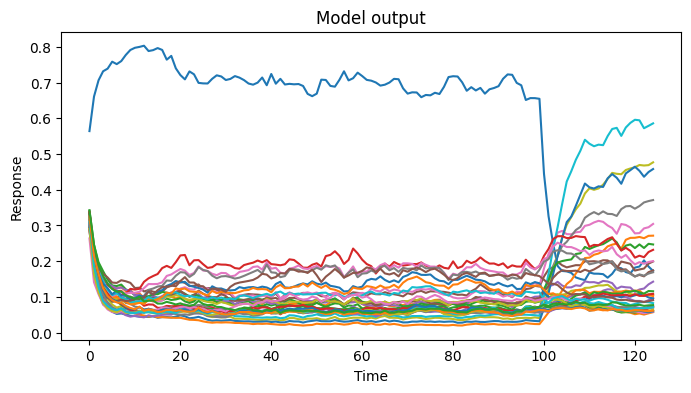

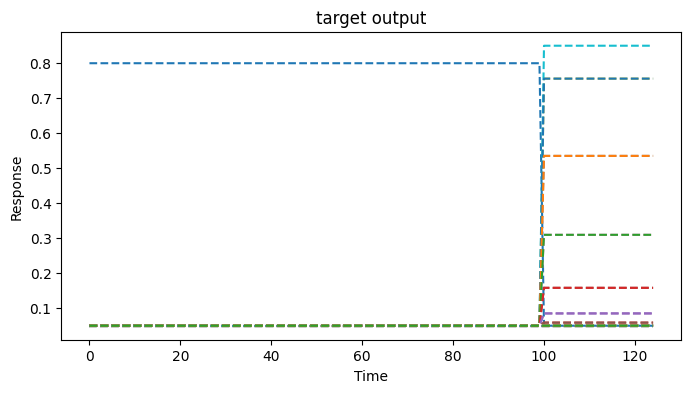

In [43]:
### plot target vs prediction over time

k =10
out = output[:,k,:]
tar = trial.y[:,k,:]

plt.figure(figsize=(8, 4))

plt.plot(out, label='Model Output')
plt.title('Model output')
plt.xlabel('Time')
plt.ylabel('Response')
plt.show()

plt.figure(figsize=(8, 4))

plt.plot(tar, label='Target Output', linestyle='--')
plt.title('target output')
plt.xlabel('Time')
plt.ylabel('Response')
plt.show()

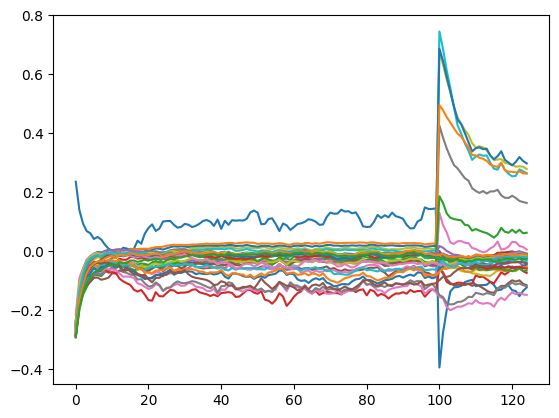

In [44]:
plt.plot(tar[:]-out[:]) # shift by one timestep
ylim = 0.05
# plt.ylim(-ylim,ylim)
# plt.xlim(100,120)
plt.show()

### playground

In [45]:
averaged = np.mean(out[-10:,:], axis = 0)
averaged_tar = np.mean(tar[-10:,:], axis = 0)


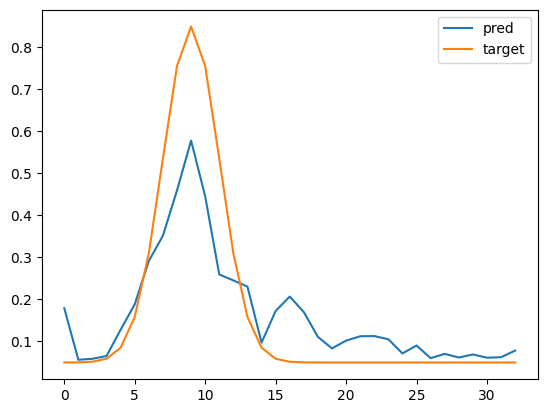

In [46]:
plt.plot(averaged, label = 'pred')
plt.plot(averaged_tar, label = 'target')
plt.legend()


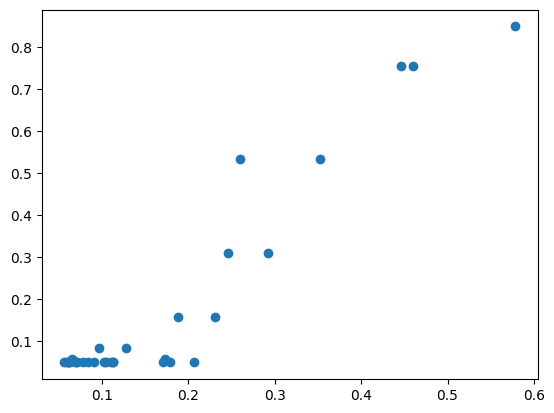

In [47]:
plt.scatter(averaged[:],averaged_tar[:])

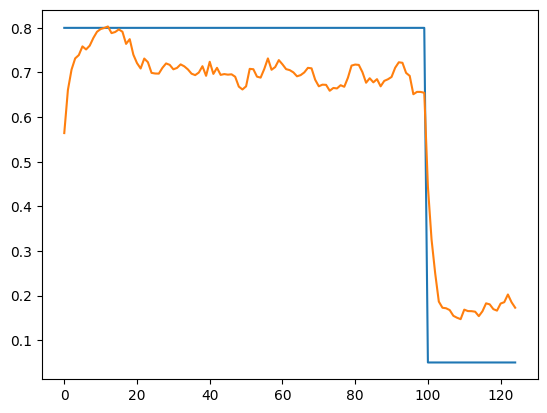

In [48]:
elem = 0
plt.plot(tar[:,elem])
plt.plot(out[:,elem])


In [2]:
import warnings
warnings.filterwarnings("ignore",message=r"Passing \(type, 1\) or '1type' as a synonym of type is deprecated",category=FutureWarning)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import argparse
import os

from train import train
from task import Trial, generate_trials
from network import Model
import tools


import matplotlib.pyplot as plt
import numpy as np
import json


2025-06-12 11:42:30.016570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 11:42:30.025390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749721350.036284  379828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749721350.039711  379828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 11:42:30.051024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
### add dale
N = 256

num_ring = 2
n_rule = 1
n_eachring = 32
n_input, n_output = 1+num_ring*n_eachring+n_rule, n_eachring+1
ruleset = 'all'
rule_trains = ['reactgo']

my_hp = {
            # batch size for training
            'batch_size_train': 64,
            # batch_size for testing
            'batch_size_test': 512,
            # input type: normal, multi
            'in_type': 'normal',
            # Type of RNNs: LeakyRNN, LeakyGRU, EILeakyGRU, GRU, LSTM
            'rnn_type': 'LeakyRNN',
            # whether rule and stimulus inputs are represented separately
            'use_separate_input': False,
            # Type of loss functions
            'loss_type': 'lsq',
            # Optimizer
            'optimizer': 'adam',
            # Type of activation runctions, relu, softplus, tanh, elu
            'activation': 'relu',
            # Time constant (ms)
            'tau': 100,
            # discretization time step (ms)
            'dt': 20,
            # discretization time step/time constant
            'alpha': 0.2,
            # recurrent noise
            'sigma_rec': 0.05,
            # input noise
            'sigma_x': 0.01,
            # leaky_rec weight initialization, diag, randortho, randgauss
            'w_rec_init': 'randortho',
            # a default weak regularization prevents instability
            'l1_h': 0,
            # l2 regularization on activity
            'l2_h': 0,
            # l2 regularization on weight
            'l1_weight': 0,
            # l2 regularization on weight
            'l2_weight': 0,
            # l2 regularization on deviation from initialization
            'l2_weight_init': 0,
            # proportion of weights to train, None or float between (0, 1)
            'p_weight_train': None,
            # Stopping performance
            'target_perf': 1.,
            # number of units each ring
            'n_eachring': n_eachring,
            # number of rings
            'num_ring': num_ring,
            # number of rules
            'n_rule': n_rule,
            # first input index for rule units
            'rule_start': 1+num_ring*n_eachring,
            # number of input units
            'n_input': n_input,
            # number of output units
            'n_output': n_output,
            # number of recurrent units
            'n_rnn': 256,
            # number of input units
            'ruleset': ruleset,
            # name to save
            'save_name': 'test',
            # learning rate
            'learning_rate': 0.001,
            # intelligent synapses parameters, tuple (c, ksi)
            'c_intsyn': 0,
            'ksi_intsyn': 0,
            }
my_hp['rng'] = np.random#.RandomState(np.random.randint(0, 1e9))
config = my_hp.copy()


model_dir = 'data/junk'
for rule in rule_trains:
    model_dir += '_'+rule

batch_size = 4096
display_step = np.ceil(100*128/batch_size)
learning_rate = batch_size/6400


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
hp = {'batch_size_train': batch_size,
        'activation': 'relu',
        'target_perf' : 1,
        'n_rnn': N,
        'mix_rule': False,
        'l1_h': 0.,
        'use_separate_input':False,
        'learnin_rate':learning_rate,
        'rng':np.random}

dale = 1
neur_type = np.ones(N, dtype=np.float32)
neur_type[:int(N*dale)] *= -1
np.random.shuffle(neur_type)
hp['neur_type'] = neur_type

# train(model_dir,
#         seed=17,
#         hp=hp,
#         ruleset=ruleset,
#         rule_trains=rule_trains,
#         display_step=display_step)

In [3]:
### load

with open(model_dir+'/hp.json', 'r') as f:
    hp = json.load(f)

hp['rng'] = np.random

tf.reset_default_graph()
model = Model(model_dir=model_dir, hp=hp)

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, model_dir+'/model.ckpt') 


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from data/junk_reactgo/model.ckpt


In [37]:
# dir(model)
model.var_list

[<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(185, 100) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'output/weights:0' shape=(100, 33) dtype=float32_ref>,
 <tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>]

In [3]:
# code to write a sample trial
def write_sample_trial():

        dt = config['dt']
        rng = config['rng']
        batch_size = 1
        anti_response = False

        # # each batch consists of sequences of equal length
        # # A list of locations of fixation points and fixation off time
        stim_ons = int(rng.uniform(500,2500)/dt)
        tdim = int(500/dt) + stim_ons

        # # A list of locations of stimuluss (they are always on)
        stim_locs = rng.uniform(0, 2*np.pi, (batch_size,))

        stim_mod  = rng.choice([1,2])


        '''elif mode == 'test':
        tdim = int(2500/dt)
        n_stim_loc, n_stim_mod = batch_shape = 20, 2
        batch_size = np.prod(batch_shape)
        ind_stim_loc, ind_stim_mod = np.unravel_index(range(batch_size),batch_shape)

        stim_ons  = int(2000/dt)
        stim_locs  = 2*np.pi*ind_stim_loc/n_stim_loc
        stim_mod   = ind_stim_mod + 1

        elif mode == 'psychometric':
        p = kwargs['params']
        stim_locs = p['stim_locs']
        batch_size = len(stim_locs)

        # Time of stimuluss on/off
        stim_ons = int(1000/dt)
        tdim = int(400/dt) + stim_ons
        stim_mod   = 1

        else:
        raise ValueError('Unknown mode: ' + str(mode))'''

        # # time to check the saccade location
        check_ons  = stim_ons + int(100/dt)

        # # Response locations
        stim_locs = np.array(stim_locs)
        if not anti_response:
                response_locs = stim_locs
        else:
                response_locs = (stim_locs+np.pi)%(2*np.pi)




        trial = Trial(config, tdim, batch_size)
        trial.add('fix_in')
        trial.add('stim', stim_locs, ons=stim_ons, mods=stim_mod)
        trial.add('fix_out', offs=stim_ons)
        trial.add('out', response_locs, ons=stim_ons)
        trial.add_c_mask(pre_offs=stim_ons, post_ons=check_ons)

        # trial.epochs = {'fix1'     : (None, stim_ons),
        #                 'go1'      : (stim_ons, None)}

        print('\n\n\n')
        print(dir(trial))
        print('\n\n\n')
        print(np.sum(trial.x))
        print('\n\n\n')
        print(np.sum(trial.y))


        print('\n\n\n')
        print(trial.x.shape)
        print('\n\n\n')
        print(trial.y.shape)

        X = trial.x
        X = X.reshape((X.shape[0], -1))
        Y = trial.y
        Y = Y.reshape((Y.shape[0], -1))
        np.savetxt(args.modeldir+'/trial_x.txt', X)
        np.savetxt(args.modeldir+'/trial_y.txt', Y)
# write_sample_trial()

In [ ]:
from tensorflow.python.ops import nn_ops


<tf.Tensor 'Relu_3:0' shape=() dtype=int32>